In [1]:
import pandas as pd
import requests
import json
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
from typing import Callable
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [2]:
cg.get_price(ids='ripple', vs_currencies='usd')

{'ripple': {'usd': 0.391841}}

In [3]:
cg.get_price(ids='ripple', vs_currencies='usd', include_market_cap='true', include_24hr_vol='true', include_24hr_change='true', include_last_updated_at='true')

{'ripple': {'usd': 0.39194,
  'usd_market_cap': 19694076806.65834,
  'usd_24h_vol': 550414227.1907903,
  'usd_24h_change': -0.9802783374664022,
  'last_updated_at': 1670109720}}

In [4]:
xrp_result = cg.get_coin_market_chart_range_by_id(id='ripple',vs_currency='usd',from_timestamp='1387026000',to_timestamp='1669774337')
xrp_result

{'prices': [[1387065600000, 0.0290606],
  [1387152000000, 0.0234149],
  [1387238400000, 0.0183658],
  [1387324800000, 0.0168461],
  [1387411200000, 0.0207833],
  [1387497600000, 0.0214271],
  [1387584000000, 0.0215525],
  [1387670400000, 0.0220126],
  [1387756800000, 0.0231614],
  [1387843200000, 0.0225342],
  [1387929600000, 0.0219629],
  [1388016000000, 0.0243375],
  [1388102400000, 0.0264432],
  [1388188800000, 0.0273354],
  [1388275200000, 0.0272621],
  [1388361600000, 0.0276683],
  [1388448000000, 0.0274381],
  [1388534400000, 0.0270432],
  [1388620800000, 0.028997],
  [1388707200000, 0.0276943],
  [1388793600000, 0.0280872],
  [1388880000000, 0.0249197],
  [1388966400000, 0.0255103],
  [1389052800000, 0.0237737],
  [1389139200000, 0.0231652],
  [1389225600000, 0.0226096],
  [1389312000000, 0.0225619],
  [1389398400000, 0.0239417],
  [1389484800000, 0.0221986],
  [1389571200000, 0.0216556],
  [1389657600000, 0.021214],
  [1389744000000, 0.0222549],
  [1389830400000, 0.0210663],
  

In [5]:
def unix_time(year, month, day, hour, second):
    date_time = datetime.datetime(year, month, day, hour, second)
    return time.mktime(date_time.timetuple())

def human_time(unix_time):
    return datetime.datetime.fromtimestamp(unix_time)

In [6]:
start_time = unix_time(2013, 12 , 14, 0 ,0)
end_time = unix_time(2022, 11, 27, 0, 0)
print(f"start_time: {start_time}")
print(f"end_time: {end_time}")

start_time: 1386997200.0
end_time: 1669525200.0


In [7]:
start_date = pd.to_datetime(start_time, unit='ms')
end_date = pd.to_datetime(end_time, unit='ms')
print(f"start_date: {start_date}")
print(f"end_date: {end_date}")

start_date: 1970-01-17 01:16:37.200000
end_date: 1970-01-20 07:45:25.200000


In [8]:
type(xrp_result)

dict

In [9]:
xrp_result['prices'][:][:][1]

[1387152000000, 0.0234149]

In [10]:
lstPrices=[]
lstTimeStamps=[]
for item in xrp_result['prices']:
    lstTimeStamps.append(item[0])
    lstPrices.append(item[1])

dictCrypto = {'Timestamps':lstTimeStamps,'Close':lstPrices}

dfRipple = pd.DataFrame(dictCrypto)

dfRipple['Timestamps']=pd.to_datetime(dfRipple['Timestamps'], unit='ms')

dfRipple

,Timestamps,Close
0,2013-12-15,0.029061
1,2013-12-16,0.023415
2,2013-12-17,0.018366
3,2013-12-18,0.016846
4,2013-12-19,0.020783
...,...,...
3268,2022-11-26,0.410613
3269,2022-11-27,0.398699
3270,2022-11-28,0.399019
3271,2022-11-29,0.391590


In [11]:
dfRipple.isnull().sum()

Timestamps    0
Close         0
dtype: int64

In [12]:
dfRipple.duplicated().sum()

0

In [13]:
dfRipple.dropna()

,Timestamps,Close
0,2013-12-15,0.029061
1,2013-12-16,0.023415
2,2013-12-17,0.018366
3,2013-12-18,0.016846
4,2013-12-19,0.020783
...,...,...
3268,2022-11-26,0.410613
3269,2022-11-27,0.398699
3270,2022-11-28,0.399019
3271,2022-11-29,0.391590


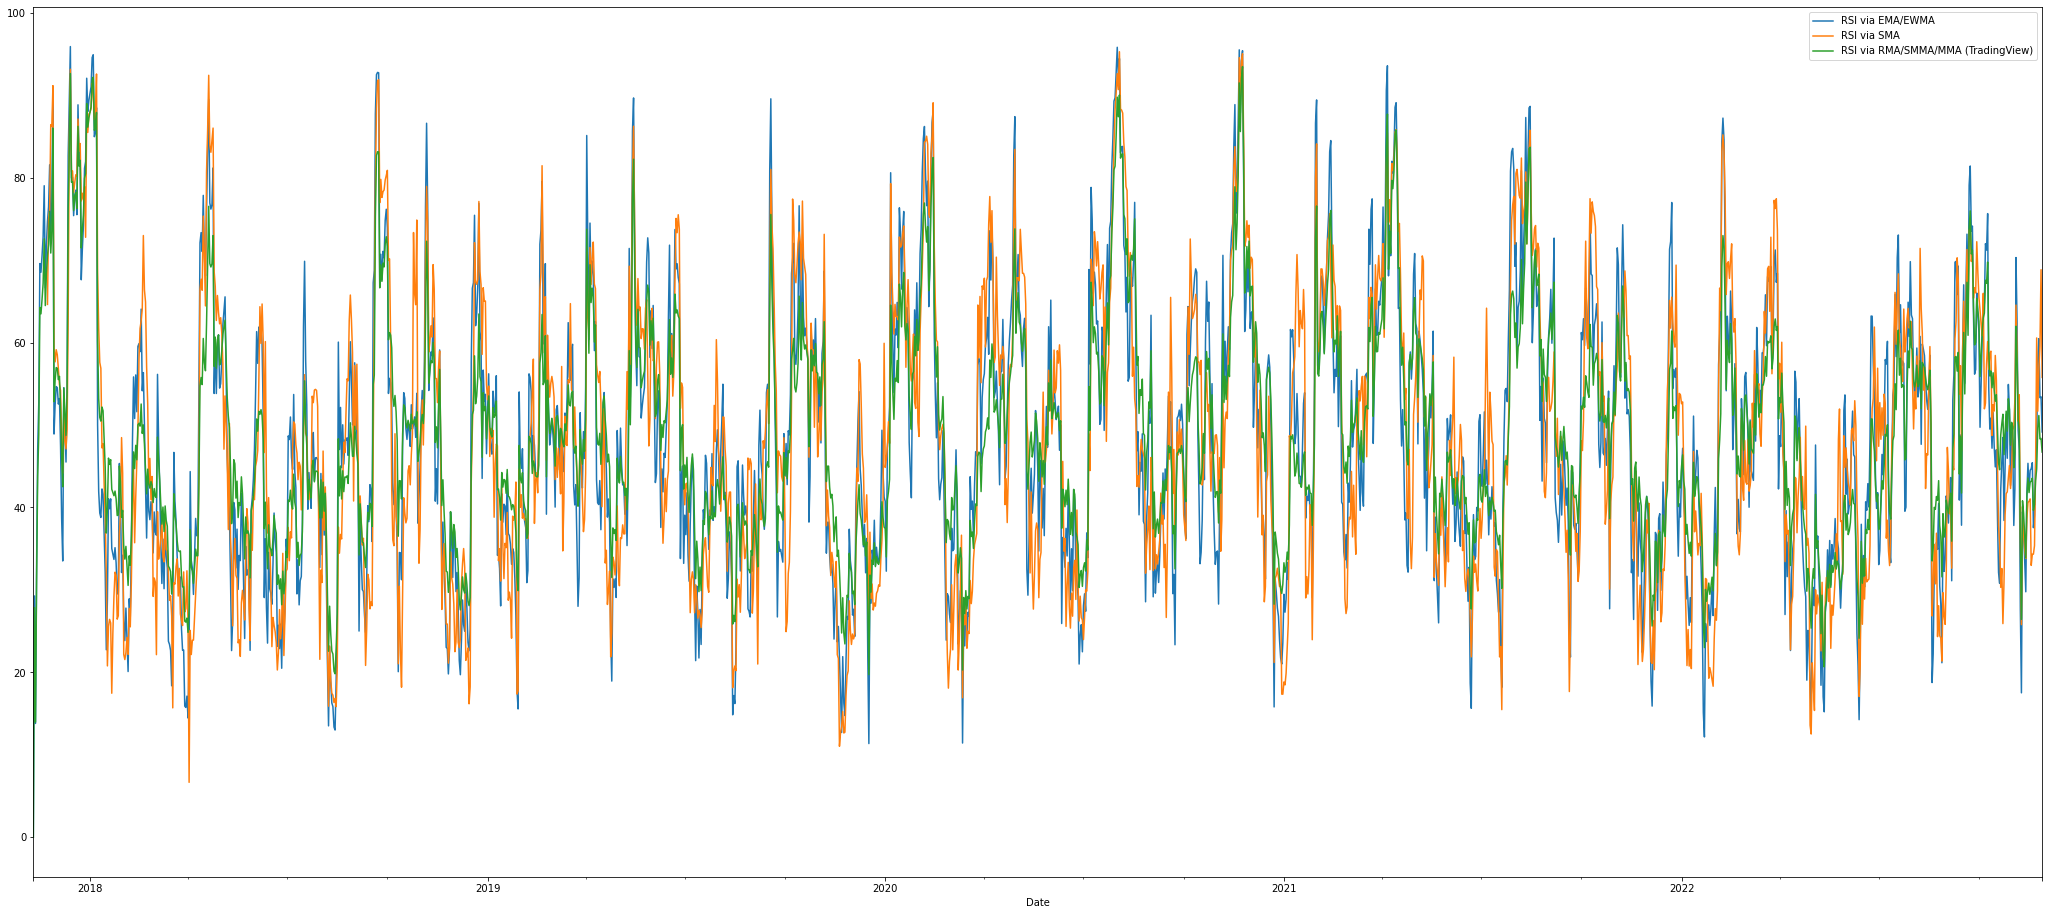

In [63]:
# Window length for moving average
length = 14

# Dates
start, end = '2013-12-14', '2022-11-27'

# Get data
data = web.DataReader('XRP-USD', 'yahoo', start, end)
# Get just the adjusted close
close = data['Adj Close']

# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
# Get the difference in price from previous step
    delta = over.diff()
# Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 
# Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

# Avoid division-by-zero if `roll_down` is zero
# This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

# Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
# Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

# Calculate RSI using MA of choice
# Reminder: Provide ≥ `1 + length` extra data points!
rsi_ema = calc_rsi(close, lambda s: s.ewm(span=length).mean())
rsi_sma = calc_rsi(close, lambda s: s.rolling(length).mean())
rsi_rma = calc_rsi(close, lambda s: s.ewm(alpha=1 / length).mean())  # Approximates TradingView.

# Compare graphically
plt.figure(figsize=(36, 16))
rsi_ema.plot(), rsi_sma.plot(), rsi_rma.plot()
plt.legend(['RSI via EMA/EWMA', 'RSI via SMA', 'RSI via RMA/SMMA/MMA (TradingView)'])
plt.show()